# Partial Dependency Plots and Individual Conditional Expectation 

Example to run univariate partial dependency plot (PDP) of a model depending on multiple features or predictors. The method is based on the technique of marginalization and assumes that all predictors are independent. In summary, in order to highlight the dependence of the model on a given feature we integrate over the remaining ones. Alternatively, we can plot the individual conditional expectation (ICE), i.e. the model prediction for a fixed instance as a function of a single speficied feature. 

In [1]:
import xarray as xr
import netCDF4
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import gc
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import box
from affine import Affine
import sys
import seaborn as sns
import rasterio
import os
from collections import defaultdict
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_precision_recall_curve
from methods.partial_dependency import PDP

In [2]:
import warnings
warnings.filterwarnings('ignore')

Upload UC3 data: 

In [3]:
df = pd.read_csv(r"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/greece_pixel_dataset.csv")

In [4]:
features = [
 'Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp'
]

coordinates = ['x', 'y']

static_features = [ 
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc'
]

target = 'burned_areas'

Data cleaning and splitting: 

In [5]:
nan_fillvalue = -9999
df = df.fillna(nan_fillvalue)
time_split = int(df.time.max()*0.85)
train_df=df[df['time']<time_split]
test_df=df[df['time']>=time_split]

Fit a Random Forest and plot results: 

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2050
         1.0       0.73      0.61      0.66       634

    accuracy                           0.85      2684
   macro avg       0.81      0.77      0.79      2684
weighted avg       0.85      0.85      0.85      2684



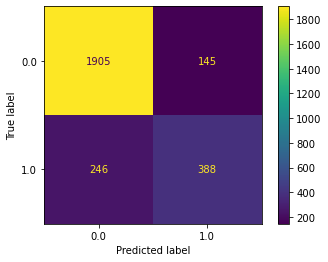

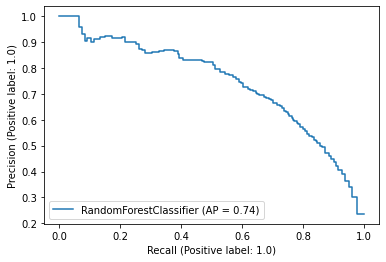

In [6]:
features_to_exclude = [
 'Fpar_500m',
 'Lai_500m',
#  'LST_Day_1km',
#  'LST_Night_1km',
#  '1 km 16 days NDVI',
#  '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
#  'era5_max_u10',
#  'era5_max_v10',
#  'era5_max_t2m',
#  'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
#  'dem_mean',
 'dem_std',
#  'aspect_mean',
 'aspect_std',
#  'slope_mean',
#  'slope_std',
#  'roads_density_2020',
#  'population_density',
#  'clc'
]
features_filtered = [x for x in features + static_features if x not in features_to_exclude]

X_train, X_test = train_df[features_filtered], test_df[features_filtered]
y_train, y_test = train_df[target], test_df[target]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plot_precision_recall_curve(clf, X_test, y_test)  
plt.show()

Let us fit the PDP method for plotting the univariate relation between the model and one of the predictors we specify:

In [7]:
features_filtered

['LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'dem_mean',
 'aspect_mean',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc']

In [8]:
X_clean = np.array(X_train)
index_filtered = np.where(X_clean[:,features_filtered.index("LST_Day_1km")]!= nan_fillvalue)
X_clean = X_clean[index_filtered,:]
X_clean = np.squeeze(X_clean)

In [9]:
config = {
    "model": clf,
    "method": "PDP",
    "instance": [0],
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"LST_Day_1km",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/pdp_LST_Day_1km.png"
}

In [10]:
pdep = PDP(config)
ypartial = pdep.fit()

Estimating  LST_Day_1km  PDP with  53  samples!


In [11]:
list(zip(*(sorted(zip([3,2,1], [0,4,2])))))

[(1, 2, 3), (2, 4, 0)]

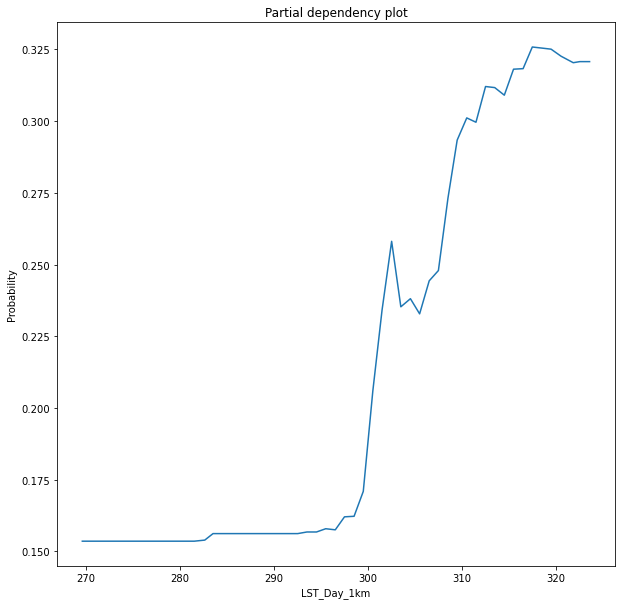

In [12]:
pdep.plot(ypartial)

In [14]:
config = {
    "model": clf,
    "method": "ICE",
    "instance": list(range(100)),
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"LST_Day_1km",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/ice_LST_Day_1km.png"
}

In [15]:
pdep = PDP(config)
ypartial, x = pdep.fit()

Estimating  LST_Day_1km  PDP with  53  samples!
Instance number :  0
LST_Day_1km  =  284.34000000000003
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  57240000.0
1 km 16 days EVI  =  27170000.0
era5_max_u10  =  1.878366
era5_max_v10  =  4.3515725
era5_max_t2m  =  283.63522
era5_max_tp  =  0.0013841093
dem_mean  =  619.5181
aspect_mean  =  178.65598
slope_mean  =  16.540434
slope_std  =  5.500697
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  29.0
Instance number :  1
LST_Day_1km  =  287.96
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  42230000.0
1 km 16 days EVI  =  16570000.0
era5_max_u10  =  2.4265573
era5_max_v10  =  3.6563377
era5_max_t2m  =  284.28867
era5_max_tp  =  3.8295984e-06
dem_mean  =  503.36057
aspect_mean  =  234.02823
slope_mean  =  9.018369
slope_std  =  4.7802734
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  29.0
Instance number :  2
LST_Day_1km  =  283.62
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  46470000.0
1 km 16 days

Instance number :  28
LST_Day_1km  =  288.86
LST_Night_1km  =  278.58
1 km 16 days NDVI  =  54610000.0
1 km 16 days EVI  =  37030000.0
era5_max_u10  =  -0.3132804
era5_max_v10  =  3.8429265
era5_max_t2m  =  286.92017
era5_max_tp  =  0.0001911819
dem_mean  =  201.93712
aspect_mean  =  144.52573
slope_mean  =  6.968278
slope_std  =  5.9503856
roads_density_2020  =  1.0
population_density  =  74.84814
clc  =  21.0
Instance number :  29
LST_Day_1km  =  288.52
LST_Night_1km  =  274.66
1 km 16 days NDVI  =  57650000.0
1 km 16 days EVI  =  26320000.0
era5_max_u10  =  -2.874117
era5_max_v10  =  2.690805
era5_max_t2m  =  284.5463
era5_max_tp  =  0.013657533
dem_mean  =  99.05097
aspect_mean  =  201.3216
slope_mean  =  5.7181497
slope_std  =  3.5384629
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  12.0
Instance number :  30
LST_Day_1km  =  283.34000000000003
LST_Night_1km  =  275.26
1 km 16 days NDVI  =  58150000.0
1 km 16 days EVI  =  30840000.0
era5_max_u10  =  0.5207535
er

Instance number :  54
LST_Day_1km  =  293.16
LST_Night_1km  =  277.64
1 km 16 days NDVI  =  54760000.0
1 km 16 days EVI  =  37520000.0
era5_max_u10  =  0.4351685
era5_max_v10  =  -2.0084193
era5_max_t2m  =  291.48108
era5_max_tp  =  0.0
dem_mean  =  47.396484
aspect_mean  =  234.63303
slope_mean  =  0.04716292
slope_std  =  0.48944023
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  13.0
Instance number :  55
LST_Day_1km  =  291.72
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  44540000.0
1 km 16 days EVI  =  24130000.0
era5_max_u10  =  -9999.0
era5_max_v10  =  -9999.0
era5_max_t2m  =  -9999.0
era5_max_tp  =  -9999.0
dem_mean  =  135.65941
aspect_mean  =  241.81438
slope_mean  =  18.349165
slope_std  =  8.171282
roads_density_2020  =  4.0
population_density  =  9.466665
clc  =  26.0
Instance number :  56
LST_Day_1km  =  293.1
LST_Night_1km  =  283.86
1 km 16 days NDVI  =  56300000.0
1 km 16 days EVI  =  26070000.0
era5_max_u10  =  -1.7212371
era5_max_v10  =  4.777787


Instance number :  75
LST_Day_1km  =  295.82
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  61410000.0
1 km 16 days EVI  =  42180000.0
era5_max_u10  =  1.2988496
era5_max_v10  =  0.47793937
era5_max_t2m  =  295.65057
era5_max_tp  =  1.5303493e-05
dem_mean  =  30.728088
aspect_mean  =  188.12328
slope_mean  =  0.0
slope_std  =  0.0
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  13.0
Instance number :  76
LST_Day_1km  =  290.16
LST_Night_1km  =  282.66
1 km 16 days NDVI  =  58090000.0
1 km 16 days EVI  =  28210000.0
era5_max_u10  =  -2.1944716
era5_max_v10  =  1.155921
era5_max_t2m  =  292.7128
era5_max_tp  =  0.00049705803
dem_mean  =  579.9308
aspect_mean  =  228.05534
slope_mean  =  12.279667
slope_std  =  4.8633857
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  23.0
Instance number :  77
LST_Day_1km  =  292.2
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  55790000.0
1 km 16 days EVI  =  28670000.0
era5_max_u10  =  -1.301703
era5_max_v10  =  1.3

Instance number :  99
LST_Day_1km  =  292.40000000000003
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  47160000.0
1 km 16 days EVI  =  25560000.0
era5_max_u10  =  2.6788373
era5_max_v10  =  1.3508167
era5_max_t2m  =  287.67868
era5_max_tp  =  0.0068593547
dem_mean  =  529.1627
aspect_mean  =  224.3526
slope_mean  =  10.992048
slope_std  =  5.5940223
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  21.0


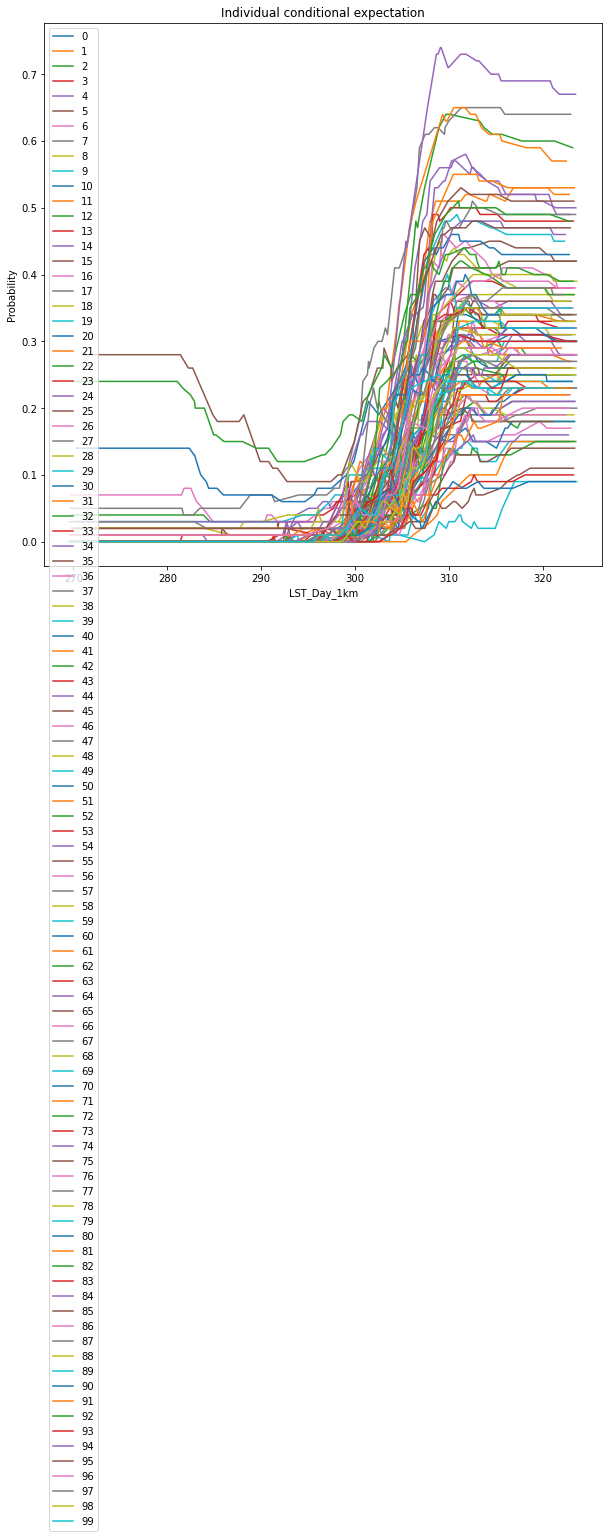

In [16]:
pdep.plot(ypartial, x=x)

We can also call the run_all() method if we want to fit the PDP algorithm and plot the results at the same time:

Instance number :  0
LST_Day_1km  =  284.34000000000003
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  57240000.0
1 km 16 days EVI  =  27170000.0
era5_max_u10  =  1.878366
era5_max_v10  =  4.3515725
era5_max_t2m  =  283.63522
era5_max_tp  =  0.0013841093
dem_mean  =  619.5181
aspect_mean  =  178.65598
slope_mean  =  16.540434
slope_std  =  5.500697
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  29.0
Instance number :  1
LST_Day_1km  =  287.96
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  42230000.0
1 km 16 days EVI  =  16570000.0
era5_max_u10  =  2.4265573
era5_max_v10  =  3.6563377
era5_max_t2m  =  284.28867
era5_max_tp  =  3.8295984e-06
dem_mean  =  503.36057
aspect_mean  =  234.02823
slope_mean  =  9.018369
slope_std  =  4.7802734
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  29.0
Instance number :  2
LST_Day_1km  =  283.62
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  46470000.0
1 km 16 days EVI  =  22110000.0
era5_max_u10  =  -9999.0
era

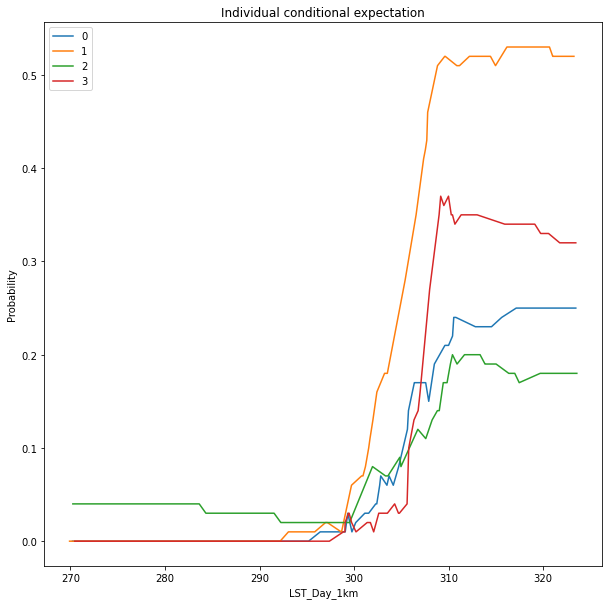

In [12]:
pdep.run_all()

Method performance: 

In [13]:
%timeit pdep.fit()

29.9 s ± 1.81 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let us plot the PDP for population density:

In [14]:
X_clean = np.array(X_train)
index_filtered = np.where(X_clean[:,features_filtered.index("population_density")]!= nan_fillvalue)
X_clean = X_clean[index_filtered,:]
X_clean = np.squeeze(X_clean)

In [17]:
config = {
    "model": clf,
    "method": "PDP",
    "instance": 0,
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"population_density",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/pdp_population_density.png"
}

Estimating  population_density  PDP with  100  samples!
Feature  population_density  importance:  0.06589999999999996


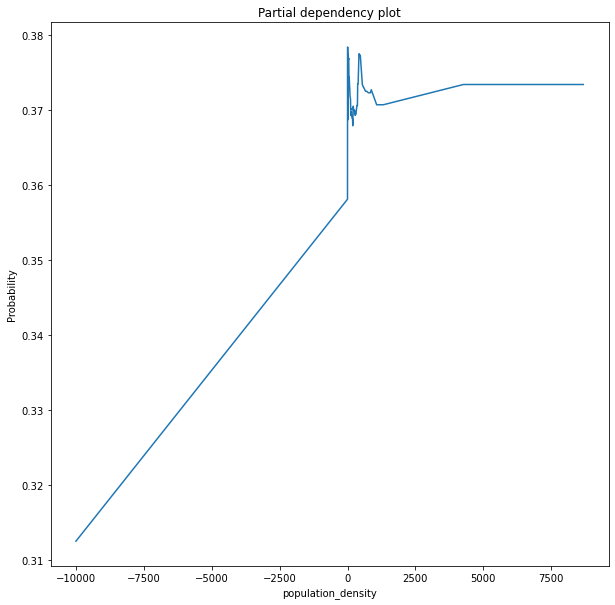

In [18]:
pdep = PDP(config)
pdep.run_all()

Let us plot the PDP and ICE for the wind direction v: 

In [19]:
X_clean = np.array(X_train)
index_filtered = np.where(X_clean[:,features_filtered.index("era5_max_v10")]!= nan_fillvalue)
X_clean = X_clean[index_filtered,:]
X_clean = np.squeeze(X_clean)

In [20]:
config = {
    "model": clf,
    "method": "PDP",
    "instance": 0,
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"era5_max_v10",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/pdp_era5_max_v10.png"
}

Estimating  era5_max_v10  PDP with  28  samples!
Feature  era5_max_v10  importance:  0.04571428571428571


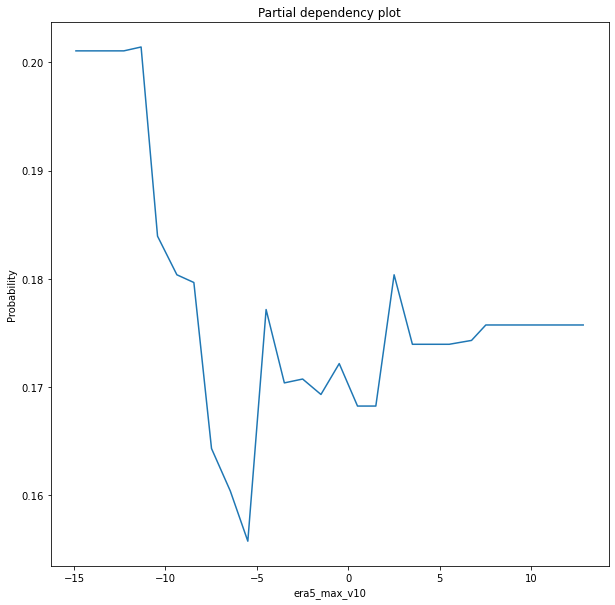

In [21]:
pdep = PDP(config)
pdep.run_all()

In [22]:
config = {
    "model": clf,
    "method": "ICE",
    "instance": 0,
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"era5_max_v10",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/ice_era5_max_v10.png"
}

Estimating  era5_max_v10  PDP with  28  samples!
Instance number :  0
LST_Day_1km  =  -9999.0
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  44050000.0
1 km 16 days EVI  =  23060000.0
era5_max_u10  =  0.79484916
era5_max_v10  =  0.31691074
era5_max_t2m  =  280.3381
era5_max_tp  =  0.0016517565
dem_mean  =  582.0038
aspect_mean  =  157.80649
slope_mean  =  8.457027
slope_std  =  4.7070537
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  26.0
Feature  era5_max_v10  importance:  0.13


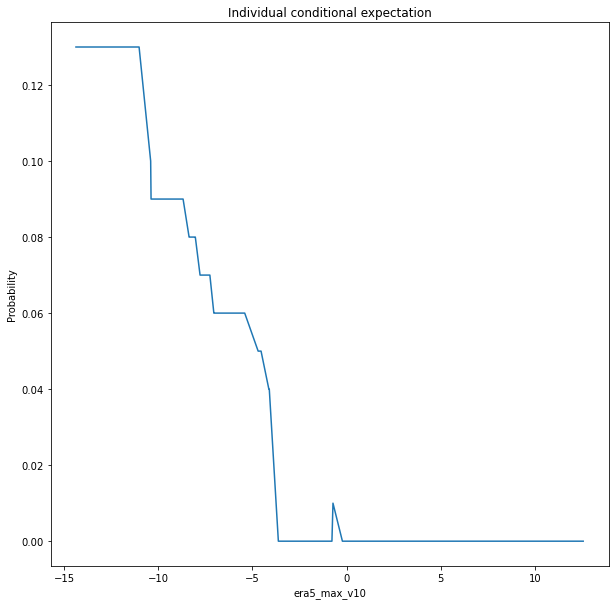

In [23]:
pdep = PDP(config)
pdep.run_all()

PDP for  era5_max_t2m:

In [24]:
X_clean = np.array(X_train)
index_filtered = np.where(X_clean[:,features_filtered.index("era5_max_t2m")]!= nan_fillvalue)
X_clean = X_clean[index_filtered,:]
X_clean = np.squeeze(X_clean)

In [25]:
config = {
    "model": clf,
    "method": "PDP",
    "instance": 0,
    "X": X_clean, 
    "features": features_filtered,
    "predictor":"era5_max_t2m",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/pdp_era5_max_t2m.png"
}

Estimating  era5_max_t2m  PDP with  43  samples!
Feature  era5_max_t2m  importance:  0.13976744186046514


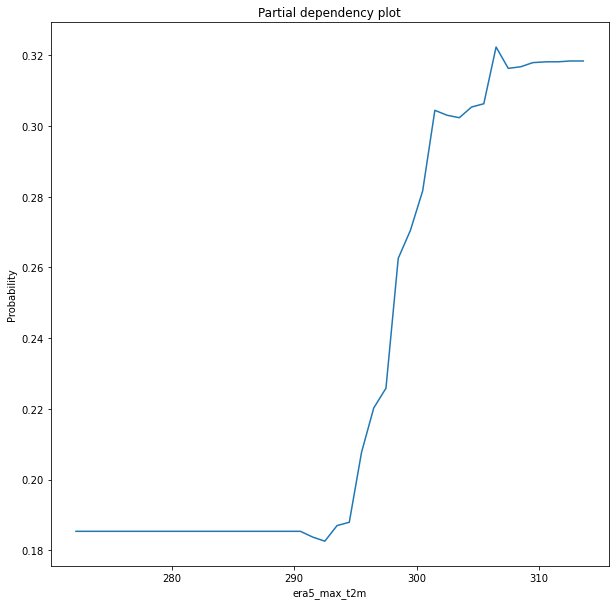

In [26]:
pdep = PDP(config)
pdep.run_all()

PDP for LST_Night_1km:

In [27]:
X_clean = np.array(X_train)
index_filtered = np.where(X_clean[:,features_filtered.index("LST_Night_1km")]!= nan_fillvalue)
X_clean = X_clean[index_filtered,:]
X_clean = np.squeeze(X_clean)

In [28]:
config = {
    "model": clf,
    "X": X_clean,
    "method": "PDP",
    "instance": 0,
    "features": features_filtered,
    "predictor":"LST_Night_1km",
    "type": "predict_proba",
    "decimal": 0,
    "nsample": 100,
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/pdp_LST_Night_1km.png"
}

Estimating  LST_Night_1km  PDP with  39  samples!
Feature  LST_Night_1km  importance:  0.2941025641025641


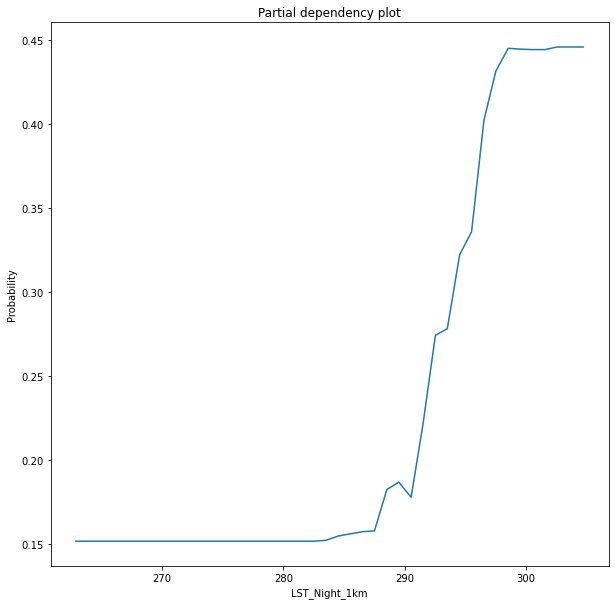

In [29]:
pdep = PDP(config)
pdep.run_all()